<a href="https://colab.research.google.com/github/Venky0892/Housing-Price-Prediction/blob/main/Airbnb_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the neccessary libraries

In [1]:
#Import linear algebra and data manipulation
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

In [2]:
#Lets dive into the listing dataset to explore host location, fees, etc.

listing_data = pd.read_csv('listings.csv')
listing_data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,

In [3]:
print('Total number of rows is {} and columns is {}'.format(listing_data.shape[0], listing_data.shape[1]))

Total number of rows is 3818 and columns is 92


In [4]:
#Lets find the total number of host and their listings
id = listing_data['id'].count()
host = len(listing_data['host_id'].unique())
print('There are {} listing given by {} hosts'.format(id, host))

There are 3818 listing given by 2751 hosts


In [5]:
# Lets dive into the data to check about missing informtion our data
no_nulls = set(listing_data.columns[listing_data.isnull().mean()==0])
print('There are {} columns with no missing data'.format(len(no_nulls)))

#Missing columns %
nulls_columns = listing_data.isnull().mean()*100
columns_with_nan = nulls_columns[nulls_columns > 0]

#Lets checks which columns have more missing data
most_missing_cols = set(listing_data.columns[listing_data.isnull().mean() > 0.75])
print('There are {} columns with more than 75% missing data'.format(len(most_missing_cols)))


There are 47 columns with no missing data
There are 2 columns with more than 75% missing data


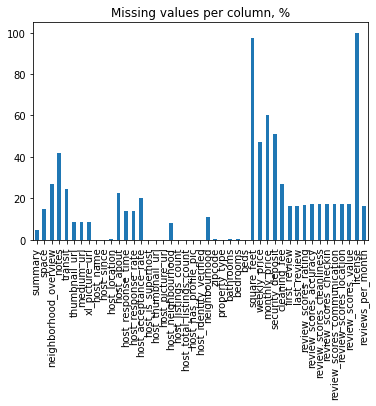

In [6]:
#Missing values columns
#plot the results
columns_with_nan.plot.bar(title='Missing values per column, %')

In [7]:
# We can see that there are two columns Square feet and License has more than 75 % missing values and there
# are columns which has more than 40 % missing values from our data. we ll analyze those columns inorder to check whether 
# they will be useful for our analyzes.
#Lets checks which columns have more missing data
most_missing_cols_2 = set(listing_data.columns[listing_data.isnull().mean() > 0.40])
print('There are {} columns with more than 40% missing data'.format(len(most_missing_cols_2)))

listing_data.columns[listing_data.isnull().mean() > 0.40]


There are 6 columns with more than 40% missing data


Index(['notes', 'square_feet', 'weekly_price', 'monthly_price',
       'security_deposit', 'license'],
      dtype='object')

In [8]:
#Now lets look into number of categorical variables and numerical variables.
cat_df = listing_data.select_dtypes(include=['object'])
print('There are {} categorical variables in our dataset'.format(cat_df.shape[1]))

There are 62 categorical variables in our dataset


In [9]:
#lets keep aside these columns for later analyzes, whether we can try to impute missing values or ignore them completely because 
#it might overfit our machine learing model. 

In [10]:
# Lets find out the calender.csv to see how the data present

calender_data = pd.read_csv('calendar.csv')
calender_data.head()

#First and last date of the calendar
min_date = calender_data['date'].min()
max_date = calender_data['date'].max()

In [11]:
print('Number of rows = {}'. format(calender_data.shape[0]))
print('Date starting from {} and ending at {}'.format(min_date, max_date))

Number of rows = 1393570
Date starting from 2016-01-04 and ending at 2017-01-02


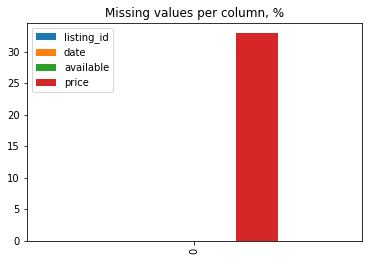

In [12]:
#lets explore the missing values in calender data 
#Missing columns %
nulls_columns_calender = pd.DataFrame([calender_data.isnull().mean()*100])
nulls_columns_calender.plot.bar(title='Missing values per column, %')

In [13]:
# As we can clearly see that we have 30 % of missing value in the price colums which we later deal with in our further analyzes.

In [14]:
#Now lets prepare the data for our final finding

# lets first merge the both dataset for data preparation 

#merge datasets using the listing id which is common for both datasets.
listing_data = listing_data.rename(index=str, columns={"id": "listing_id"})
fresh_df = pd.merge(calender_data, listing_data, on = 'listing_id')

In [15]:
fresh_df.head()


,listing_id,date,available,price_x,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,bedrooms,beds,bed_type,amenities,square_feet,price_y,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,2016-01-04,t,$85.00,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,241032,2016-01-05,t,$85.00,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
2,241032,2016-01-06,f,NaN,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet""

In [16]:
# Since the data some missing values we gonna see which data has zero values in columns and gonna remove all the irrelavant column which might not be 
#useful for our analysis 

#drop the irrelevant columns
columns_to_drop = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
                'host_total_listings_count', 'weekly_price', 'monthly_price',
                'security_deposit', 'cleaning_fee', 'calendar_updated',
                'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
                'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
                'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
                'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
              'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
              'reviews_per_month']

df = fresh_df.drop(columns = columns_to_drop)

In [17]:
print('Now we have {} columns and {} rows in new df'.format(df.shape[1], df.shape[0]))

Now we have 37 columns and 1393570 rows in new df


In [18]:
#Now our data columns have been shrunk to relevant information neccessary por our analysis.

# Lets convert the date column 

#convert date from the calendar into month and drop the date colum
df['month'] = df.apply(lambda row:int(row['date'].split('-')[1]),axis=1)
df['year'] = df.apply(lambda row:int(row['date'].split('-')[0]),axis=1)
df = df.drop(columns = ['date'])

In [19]:
df.head()

,listing_id,price_x,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,month,year
0,241032,$85.00,2011-08-11,within a few hours,96%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,$5.00,1,365,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,1,2016
1,241032,$85.00,2011-08-11,within a few hours,96%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,$5.00,1,365,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,1,2016
2,241032,NaN,2011-08-11,within a few hours,96%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,$5.00,1,365,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,1,2016
3,241032,NaN,2011-08-11,within a few hours,96%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,$5.00,1,365,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,1,2016
4,241032,NaN,2011-08-11,within a few hours,96%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,$5.00,1,365,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,1,2016


In [20]:
#Lets remove rows which contains nan, price will be the column we ll try to find later 
df = df.dropna(subset=['price_x'])

In [22]:
# Lets do some cleaning since the models work better with number.

#removing the pricing label in the price colums 
df['price'] = df['price_x'].astype(str)
df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
df = df.drop(columns = ['price_x'])

In [23]:
#Converting date into number, filling the missing values and droping the column
def get_host_since_year(row):
    ''' Get year from a date represented as a string '''
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since


df['host_since_year'] = df.apply(lambda row: get_host_since_year(row),axis=1)
df['host_since_year'].fillna(df['host_since_year'].mean(), inplace = True)
df = df.drop(columns = ['host_since'])
    

In [24]:
df['host_response_rate_num'] = df['host_response_rate'].astype(str)
df['host_response_rate_num'] = df['host_response_rate_num'].str.replace("%", "").astype("float")
df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace = True)

In [25]:
#converting the response rate to Qcut of 5 for futhur analyzes
df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate_num'], 5, labels=False, duplicates = 'drop')

In [26]:
df = df.drop(columns = ['host_response_rate', 'host_response_rate_num'])



In [27]:
#now lets check for dtypes columns

num_vars = df.select_dtypes(include=['float', 'int']).columns
cat_vars = df.select_dtypes(include=['object']).copy().columns
print('Now we have data with {} columns of int type and {} columns of object type'. format(len(num_vars), len(cat_vars)))


Now we have data with 23 columns of int type and 15 columns of object type


In [28]:
#Finally lets look for missing values again.
most_missing_cols_df = set(df.columns[df.isnull().mean() > 0.5])

print("Missing value greater than 50 % is {}".format(len(most_missing_cols_df)))

#Great since we have less missing values now we can try to impute the values by mode or mean according to the data columns 
# As for simpler purpose i'm trying to fill the with mean to all mussing values in int type.




Missing value greater than 50 % is 0


In [29]:
#Imputing the missing value to the float type object with mean of the column
for col in num_vars:
  df[col].fillna((df[col].mean()), inplace=True)

In [30]:
#Imputing the missing value to the object type object with mode of the column
for col in cat_vars:
  df[col].fillna((df[col].mode()), inplace=True)

In [31]:
for col in cat_vars:
  print(col)

host_response_time
host_is_superhost
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood_group_cleansed
property_type
room_type
bed_type
amenities
extra_people
instant_bookable
cancellation_policy
require_guest_profile_picture
require_guest_phone_verification


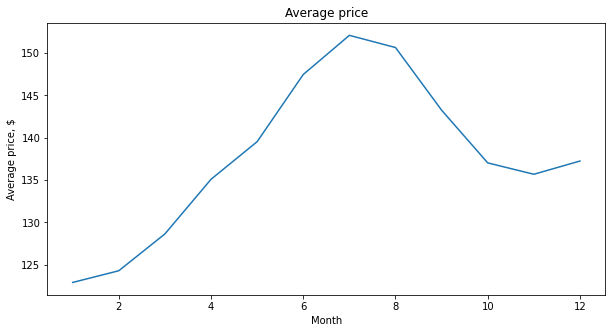

In [32]:
# lets explore some nice insights to see how pricing has been determined 
#find average price by month
average_price = df.groupby(['month'])['price'].mean()

#plot
plt.figure(figsize=(10,5))
plt.plot(average_price)
plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price')

plt.savefig('average price for month')

plt.show()
  


We can see that the price increases when the summer season starts and decline towards winter season.


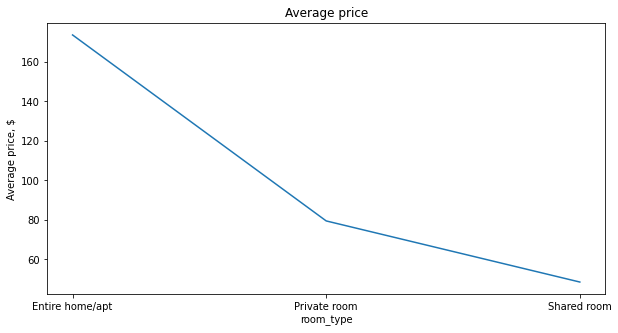

In [33]:
#Pricing against room type
average_price = df.groupby(['room_type'])['price'].mean()

#plot
plt.figure(figsize=(10,5))
plt.plot(average_price)
plt.ylabel('Average price, $')
plt.xlabel('room_type')
plt.title('Average price')

plt.savefig('average price for month')

plt.show()

Shared room's average price is under 60 $. So if your travelling in group and want to stay together shared option would be a ideal one.

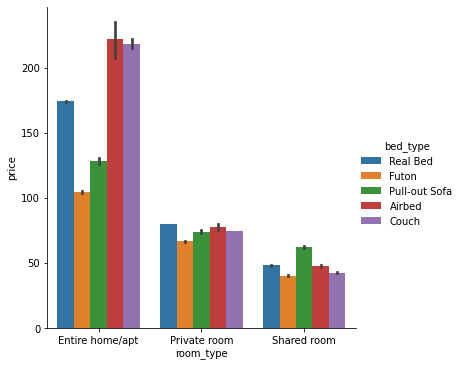

In [34]:
tips = df
sns.catplot(x="room_type", y="price", hue="bed_type", kind="bar", data=tips)

From the plot we can see that shared room types have cleary all types of bed with reasonable pricing.

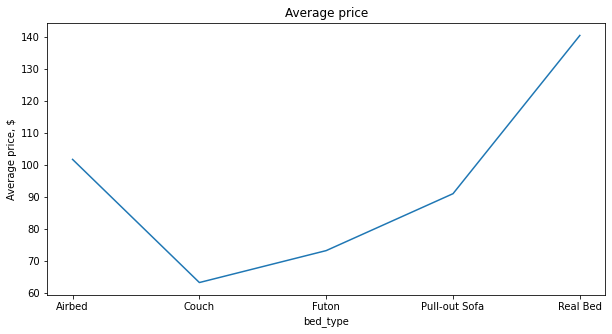

In [35]:
#Pricing of bed_type 
average_price = df.groupby(['bed_type'])['price'].mean()

#plot
plt.figure(figsize=(10,5))
plt.plot(average_price)
plt.ylabel('Average price, $')
plt.xlabel('bed_type')
plt.title('Average price')

plt.savefig('average price for bed_type')

plt.show()

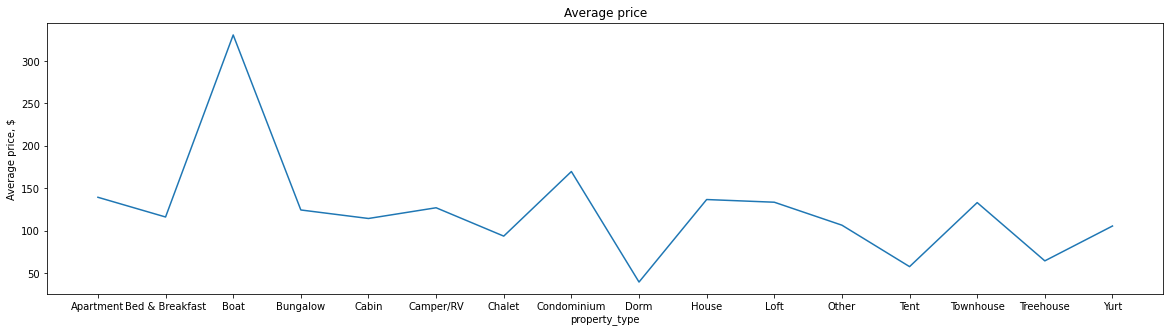

In [36]:
#Pricing based on property type.
average_price = df.groupby(['property_type'])['price'].mean()

#plot
plt.figure(figsize=(20,5))
plt.plot(average_price)
plt.ylabel('Average price, $')
plt.xlabel('property_type')
plt.title('Average price')

plt.savefig('average price for property_type')

plt.show()

Dorm based properties are less compared to the other property types and the most expensive one will be the boat type. 

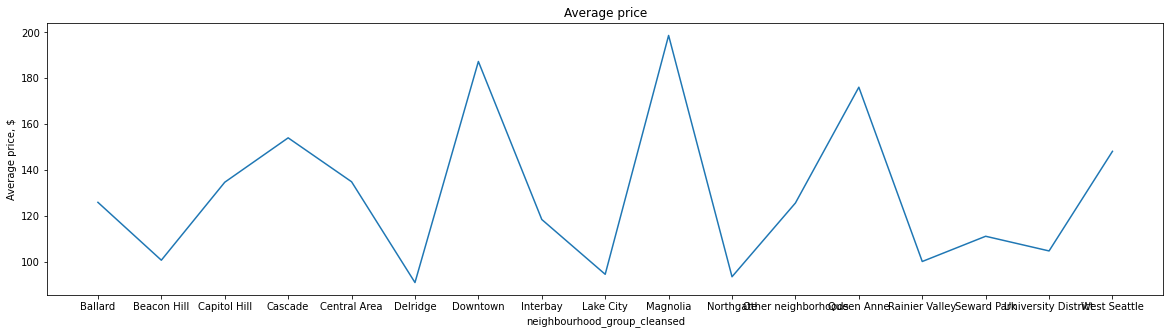

In [37]:
#Pricing based on neighbourhood_group_cleansed type.
average_price = df.groupby(['neighbourhood_group_cleansed'])['price'].mean()

#plot
plt.figure(figsize=(20,5))
plt.plot(average_price)
plt.ylabel('Average price, $')
plt.xlabel('neighbourhood_group_cleansed')
plt.title('Average price')

plt.savefig('average price for neighbourhood_group_cleansed')

plt.show()

neighbourhood_group_cleansed is clearly important feature to retain. The price depends upon the neighbourhood.

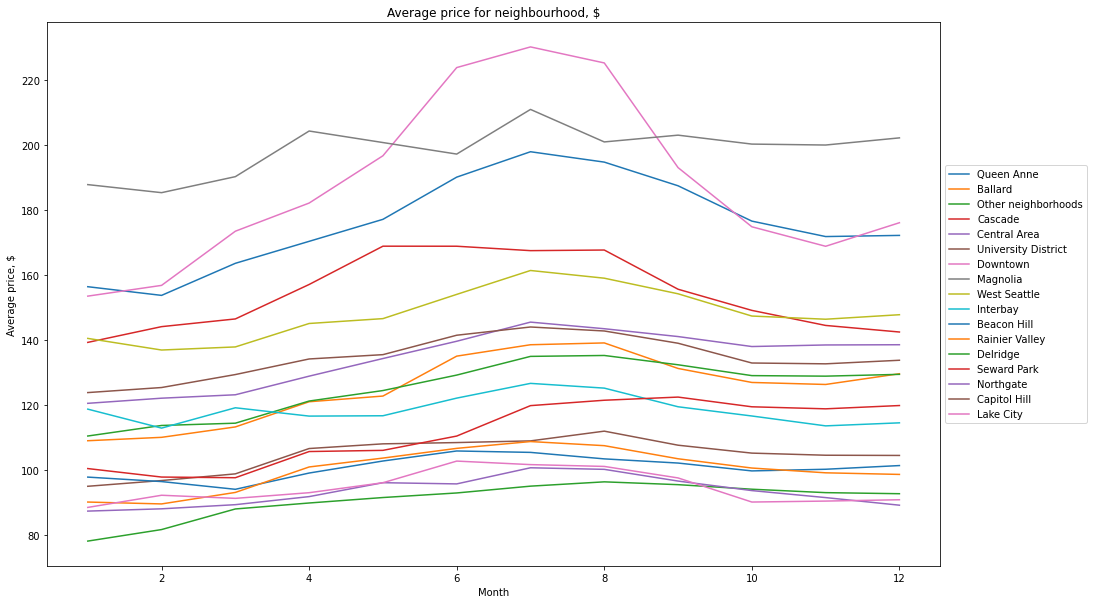

In [38]:
#get list of neighbourhoods
neighbourhoods = df['neighbourhood_group_cleansed'].unique()

#get prices by month and neighbourhood
price_by_month_neighbourhood = df.groupby(['month','neighbourhood_group_cleansed']).mean().reset_index()

#plot prices for each neighbourhood
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)

for neighbourhood in neighbourhoods:
    ax.plot(price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['month'],
             price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['price'],
             label = neighbourhood)
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price for neighbourhood, $')

plt.savefig('average price for neighbourhood')

plt.show()

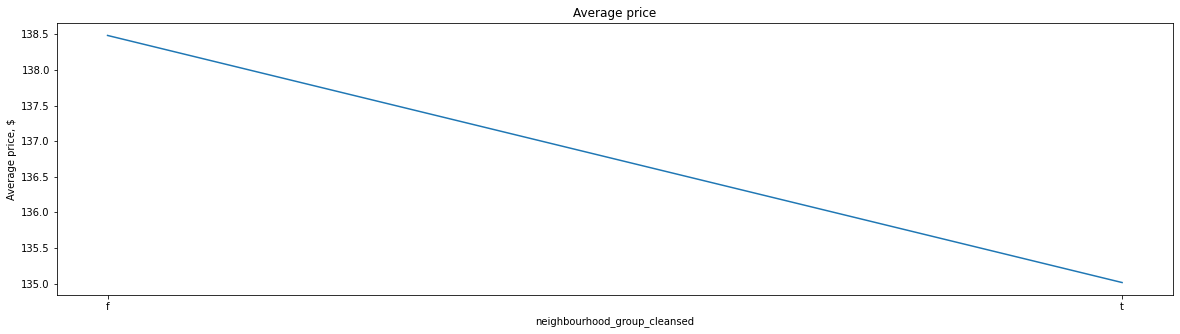

In [48]:
#

In [39]:
def get_extra_people_fee(row):
    ''' Return 1 when the is fee for exatra people '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0

df['extra_people_fee'] = df.apply(lambda row: get_extra_people_fee(row),axis=1)

In [40]:
cat_vars = df.select_dtypes(include=['object']).copy().columns
for col in cat_vars:
  print(col)

host_response_time
host_is_superhost
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood_group_cleansed
property_type
room_type
bed_type
amenities
extra_people
instant_bookable
cancellation_policy
require_guest_profile_picture
require_guest_phone_verification


In [ ]:


# lets convert categorical variable to numberic before that lets keep only the necessary categorical column
cat_vars = df.select_dtypes(include=['object']).copy().columns

cat_vars.drop(['amenities','host_is_superhost','host_verifications','host_has_profile_pic',
               'host_identity_verified','require_guest_profile_picture','require_guest_phone_verification'])

 for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    

    
# 


In [41]:
# # Creating Dummy variable for categorical column

# just_dummies = pd.get_dummies(df['host_response_time'],prefix='host_response_time', prefix_sep='_', drop_first=True)
# df = pd.concat([df.drop('host_response_time', axis=1),just_dummies], axis=1) 


In [42]:
# just_dummies_1 = pd.get_dummies(df['neighbourhood_group_cleansed'],prefix='neighbourhood_group_cleansed', prefix_sep='_', drop_first=True)
# df = pd.concat([df.drop('neighbourhood_group_cleansed', axis=1),just_dummies_1], axis=1) 


In [43]:
# just_dummies_1 = pd.get_dummies(df['property_type'],prefix='property_type', prefix_sep='_', drop_first=True)
# df = pd.concat([df.drop('property_type', axis=1),just_dummies_1], axis=1)

In [44]:
# just_dummies_1 = pd.get_dummies(df['room_type'],prefix='room_type', prefix_sep='_', drop_first=True)
# df = pd.concat([df.drop('room_type', axis=1),just_dummies_1], axis=1)

In [45]:
# just_dummies_1 = pd.get_dummies(df['bed_type'],prefix='bed_type', prefix_sep='_', drop_first=True)
# df = pd.concat([df.drop('bed_type', axis=1),just_dummies_1], axis=1)

In [46]:
# just_dummies_1 = pd.get_dummies(df['extra_people'],prefix='extra_people', prefix_sep='_', drop_first=True)
# df = pd.concat([df.drop('extra_people', axis=1),just_dummies_1], axis=1)

In [47]:
# just_dummies_1 = pd.get_dummies(df['instant_bookable'],prefix='instant_bookable', prefix_sep='_', drop_first=True)
# df = pd.concat([df.drop('instant_bookable', axis=1),just_dummies_1], axis=1)

In [48]:
# just_dummies_1 = pd.get_dummies(df['cancellation_policy'],prefix='cancellation_policy', prefix_sep='_', drop_first=True)
# df = pd.concat([df.drop('cancellation_policy', axis=1),just_dummies_1], axis=1)

In [49]:
#Note : Becareful while creating dummy variables, when you create a dummy variable/
# we want to get rid of one dummy variable to avoid the dummy variable trap.

In [50]:
# Now our dataset is clean and prepared
df = df.drop(['host_is_superhost','host_verifications','host_has_profile_pic','host_identity_verified',
              'amenities', 'require_guest_profile_picture','require_guest_phone_verification'], axis = 1)

In [51]:
df = df.drop(columns = ['listing_id', 'year'])

now data has more columns, now we need to find the best features interms of pricing. so we use feature engineering to extract the important features by using an algorithm called boruta.

Boruta iteratively removes features that are statistically less relevant than a random probe (artificial noise variables introduced by the Boruta algorithm). In each iteration, rejected variables are removed from consideration in the next iteration. It generally ends up with a good global optimization for feature selection which is why I like it

Create your Boruta object
Now create a BorutaPy feature selection object and fit your entire data to it. During the fit, Boruta will do a number of iterations of feature testing depending on the size of your dataset. Boruta creates random shadow copies of your features (noise) and tests the feature against those copies to determine if it is better than the noise, and therefore worth keeping. It automatically checks for interactions that might hurt your model. Boruta will output confirmed, tentative, and rejected variables for every iteration.
After being fit, the Boruta object has useful attributes and methods:
.support_ attribute is a boolean array that answers — should feature should be kept?
.ranking_ attribute is an int array for the rank (1 is the best feature(s))
.transform(X) method applies the suggestions and returns an array of adjusted data. In this way, you could just let Boruta manage the entire ordeal.


In [55]:
# from sklearn.ensemble import RandomForestClassifier

# y = df['price']
# # define random forest classifier
# forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# forest.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
# #Lets import the necessary libraies
# !pip install Boruta
# from boruta import BorutaPy
# # define Boruta feature selection method
# feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)
# # find all relevant features
# feat_selector.fit(X, y)


In [ ]:
# # check selected features
# feat_selector.support_

In [53]:
# Lets build our simple  baseline linear regression model 

X = df.drop(columns = 'price') # Variable to predict the price 
y = df[['price']] # Response Variable 

##Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit


#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))



'The r-squared score for the model using only quantitative variables was 0.6376591247751764 on 280363 values.'

In [54]:
#Train Random Forest Regressor model to predict price:

#Train RF regressor model
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 206.236, test: 230.136
Random Forest R^2 train: 0.981, test: 0.979


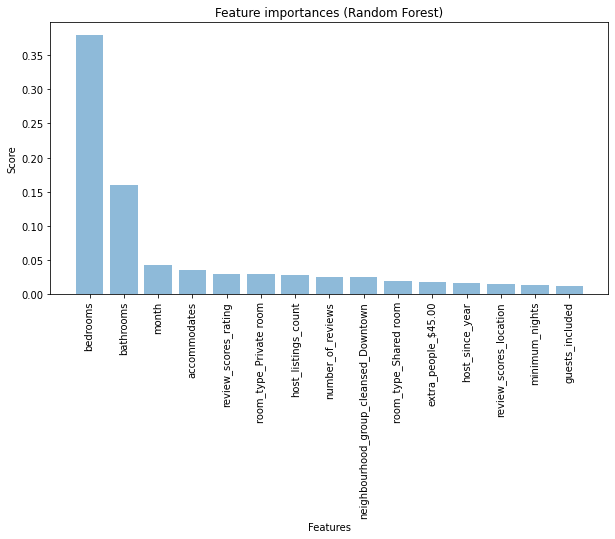

In [55]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()

In [56]:
#train XGBoost model
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)

#calculate and print scores for the model for top 15 features
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

[06:46:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE train: 1040.424, test: 1044.858
R^2 train: 0.906, test: 0.904


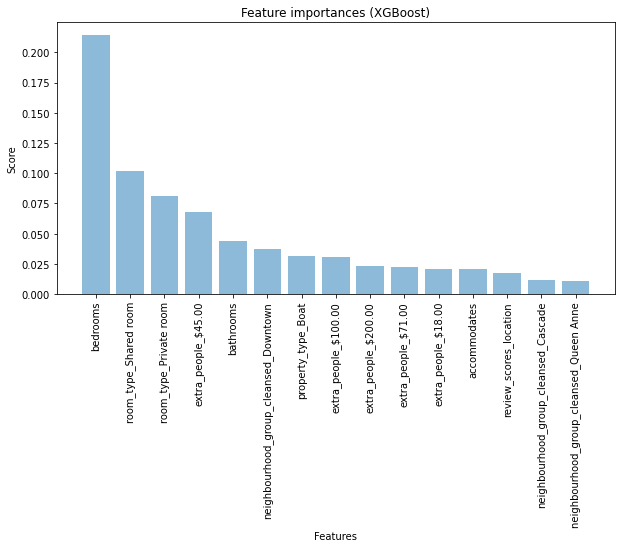

In [57]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances for top 15 features
features = xgb_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = xgb_feature_importances['score'][:15]
 
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (XGBoost)')

plt.savefig('feature importances XGB.png')
 
plt.show()


In [ ]:
# Neural network

